# INFO 103: Introduction to data science <br> Demo \# 8: Modeling <br> Author: JRW<br>Updated by: BYS

### Mission
The goal of the current workbook is to explore some basic kinds of modeling, using Python available modules. The only package that does not come in with Anaconda is haversine, which is used to measure the distances between latitude longitude points. This may be accessed using the following:

`
pip install haversine
`

The package loads are as follows.

In [4]:
!pip install haversine
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from haversine import haversine
from sklearn import svm
from scipy import stats
import matplotlib.mlab as mlab
import scipy
%matplotlib inline

In [ ]:
!pip install haversine

### Data
We're going to use two different data set for these experiments. The first consists of Indigo bikeshare trip data, which are listed on Philly's open data website:

* https://www.opendataphilly.org/dataset/indego-bike-share-trips

though actually provided by Indigo. Specifically, this data file (`trips_1000.csv`) is the first 1000 lines of the 2017 Q1 file.

The second data set we'll be using is a collection of heights, weights, ages, teams, and positions of just over 1,000 Major League Baseball (MLB) players, courtesy of UCLA statistics department:

* http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights

which is packaged with this workbook as `baseball_heightweight.csv` for convenience.

#### Load and inspect the rideshare data
Let's play with the trip duration and station locations to compare the distance traveled to duration of trip.

In [5]:
# Load the bike trips dataset
trips = pd.read_csv(filepath_or_buffer="trips_1000.csv", sep=",", header=0, parse_dates = [2, 3])
print(trips[0:10])

    trip_id  duration          start_time            end_time  \
0  87535955       660 2017-01-01 00:05:00 2017-01-01 00:16:00   
1  87535954      2160 2017-01-01 00:21:00 2017-01-01 00:57:00   
2  87535953      2100 2017-01-01 00:22:00 2017-01-01 00:57:00   
3  87535952       720 2017-01-01 00:27:00 2017-01-01 00:39:00   
4  87535951       480 2017-01-01 00:28:00 2017-01-01 00:36:00   
5  87535950       420 2017-01-01 00:29:00 2017-01-01 00:36:00   
6  87535949       540 2017-01-01 00:31:00 2017-01-01 00:40:00   
7  87535948       960 2017-01-01 00:34:00 2017-01-01 00:50:00   
8  87535947      1140 2017-01-01 00:38:00 2017-01-01 00:57:00   
9  87535946      1020 2017-01-01 00:40:00 2017-01-01 00:57:00   

   start_station_id  start_lat  start_lon  end_station_id    end_lat  \
0              3046  39.950119 -75.144722            3041  39.968491   
1              3110  39.961750 -75.136414            3054  39.962502   
2              3110  39.961750 -75.136414            3054  39.962502

#### The earth isn't flat, its a sphere
This is in fact a modeling step! We can't quite take latitude and longitude differences to get an accurate measure of station distance, so we'll use something called the haversine formula:

* https://en.wikipedia.org/wiki/Haversine_formula

to get to a distance in miles. Here's an example of how its's used

In [6]:
print("The distance between the first trips stations was "+str(haversine(
    (trips["start_lat"][0],trips["start_lon"][0]), 
    (trips["end_lat"][0],trips["end_lon"][0]), 
    unit = 'mi'
))+" miles!"
     )

The distance between the first trips stations was 1.360861287694947 miles!


#### Again, pre-processing
Now that we can compute distances, we'll have to do this for all of the trips, and while we're at it, let's convert the durations from seconds to hours. Also, just to make sure the data are all nice and clean, we'll remove any NAs that have resulted. Also, let's only look at the one-way trips, so that we never get a zero-distance traveled. 

For round-trips, and ultimately, a more accurate measurement of all trips we would need to have had GPS tracking during all bike trips, but this data just isn't there. However, we'll be able to get an idea of how far people have traveled, even if they did take a round trip from our model, just by the duration traveled!

In [7]:
distances = np.array([
    haversine((trips["start_lat"][i],trips["start_lon"][i]), (trips["end_lat"][i],trips["end_lon"][i]), unit = 'mi')
    for i in range(len(trips))
    if trips["trip_route_category"][i] == "One Way"
])

hours = np.array([
    trips["duration"][i]/3600. 
    for i in range(len(trips))
    if trips["trip_route_category"][i] == "One Way"
])

hours = hours[np.logical_not(np.isnan(distances))]
distances = distances[np.logical_not(np.isnan(distances))]

#### EDA first, always
Let's look at some box plots of our distances and times, to see if anything strange is going on

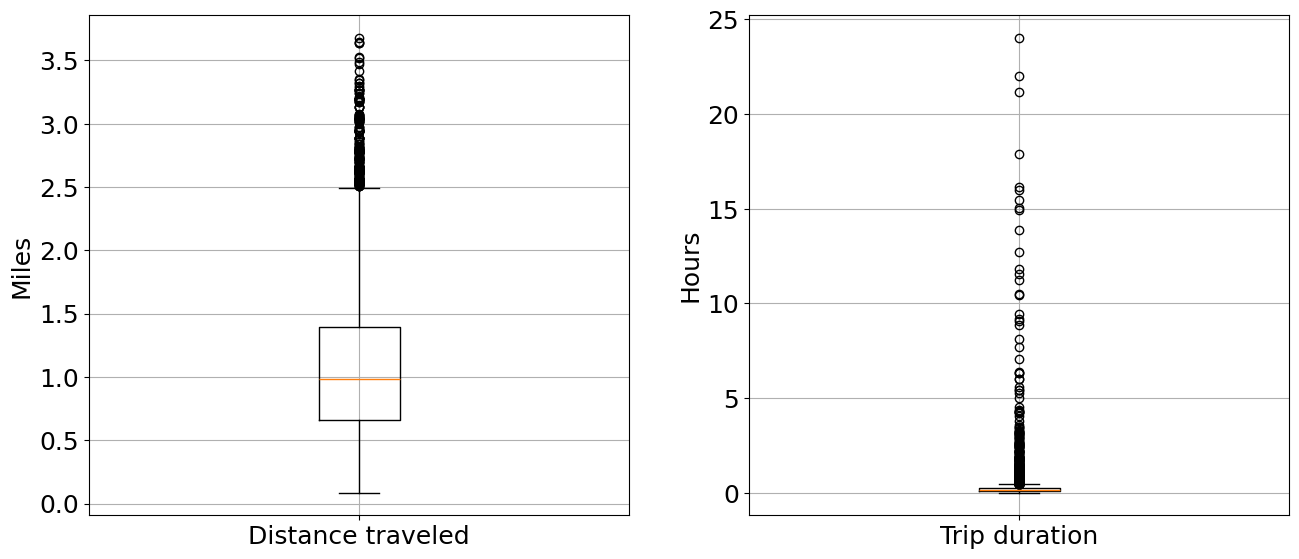

In [8]:
fig = plt.figure(figsize = (12,5))

first_ax = fig.add_axes([0, 0, 0.45, 1])

plt.boxplot(distances)
plt.xticks([1], ['Distance traveled'])
plt.ylabel('Miles', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)

second_ax = fig.add_axes([0.55, 0, 0.45, 1])

plt.boxplot(hours)
plt.xticks([1], ['Trip duration'])
plt.ylabel('Hours', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)


#### It looks like lots of people lose, or forget to return their bikes!
Notice how there are some VERY extreme outliers in the trip duration box plot. These are going to make it very difficult to observe any association between distance and duration. For simplicity, let's remove any trips that have lasted longer than three hours. How can we justify removing these points?

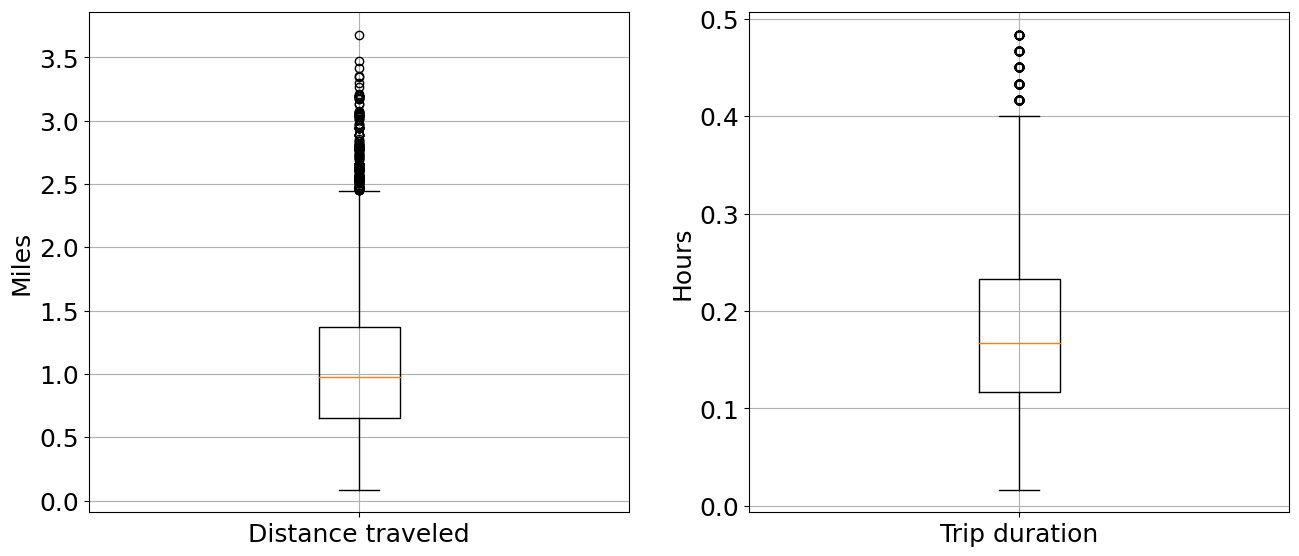

In [9]:
fig = plt.figure(figsize = (12,5))

first_ax = fig.add_axes([0, 0, 0.45, 1])

plt.boxplot([distances[i] for i in range(len(distances)) if hours[i] < 0.5])
plt.xticks([1], ['Distance traveled'])
plt.ylabel('Miles', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)

second_ax = fig.add_axes([0.55, 0, 0.45, 1])

plt.boxplot([hours[i] for i in range(len(hours)) if hours[i] < 0.5])
plt.xticks([1], ['Trip duration'])
plt.ylabel('Hours', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)

#### Much better...
Just to see the difference that we made on the data, let's make a scatter plot of the duration vs. distance before and after the removal of duration outliers. What do you see?

Text(0.5, 1.0, 'Duration vs. distance (duration $ < 0.5$ hr)')

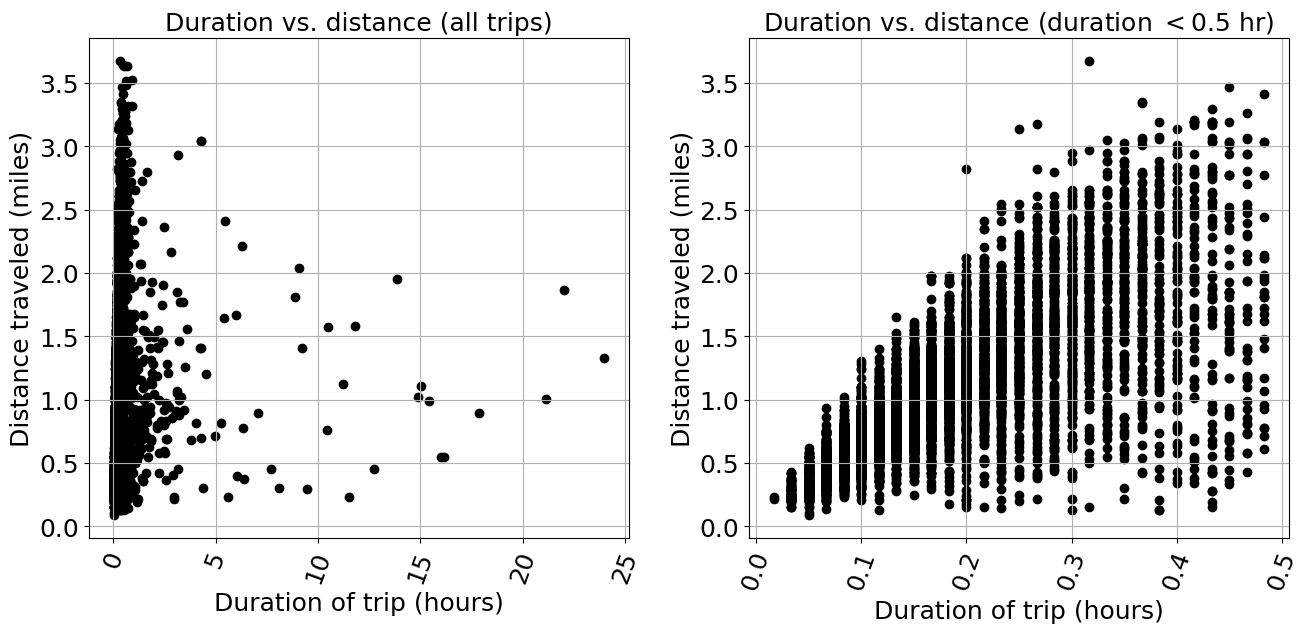

In [9]:
fig = plt.figure(figsize = (12,5))

first_ax = fig.add_axes([0, 0, 0.45, 1])

plt.scatter(hours, distances, color = 'black')
plt.xticks(rotation=70)

plt.xlabel('Duration of trip (hours)', fontsize = 18)
plt.ylabel('Distance traveled (miles)', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)

plt.title(r'Duration vs. distance (all trips)', fontsize = 18)

second_ax = fig.add_axes([0.55, 0, 0.45, 1])

plt.scatter(
    [hours[i] for i in range(len(hours)) if hours[i] < 0.5],     
    [distances[i] for i in range(len(distances)) if hours[i] < 0.5],
    color = 'black'
)
plt.xticks(rotation=70)

plt.xlabel('Duration of trip (hours)', fontsize = 18)
plt.ylabel('Distance traveled (miles)', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)

plt.title(r'Duration vs. distance (duration $ < 0.5$ hr)', fontsize = 18)

#### There's a pattern!
Okay, so the duration-outliers swamped out the interesting pattern, which is that longer trips usually result in greater distances traveled. For very short trips (e.g., 15 mins) you really can't get that far! Notice as well, that the data are discretized to 15-minute block, which are likely the pay-period for the rideshare. What do you think the trend is?

Our fit has a p-value of 0.0 and an R-squared of 0.55.
It's a reasonable association, and we're pretty sure it's that strong.


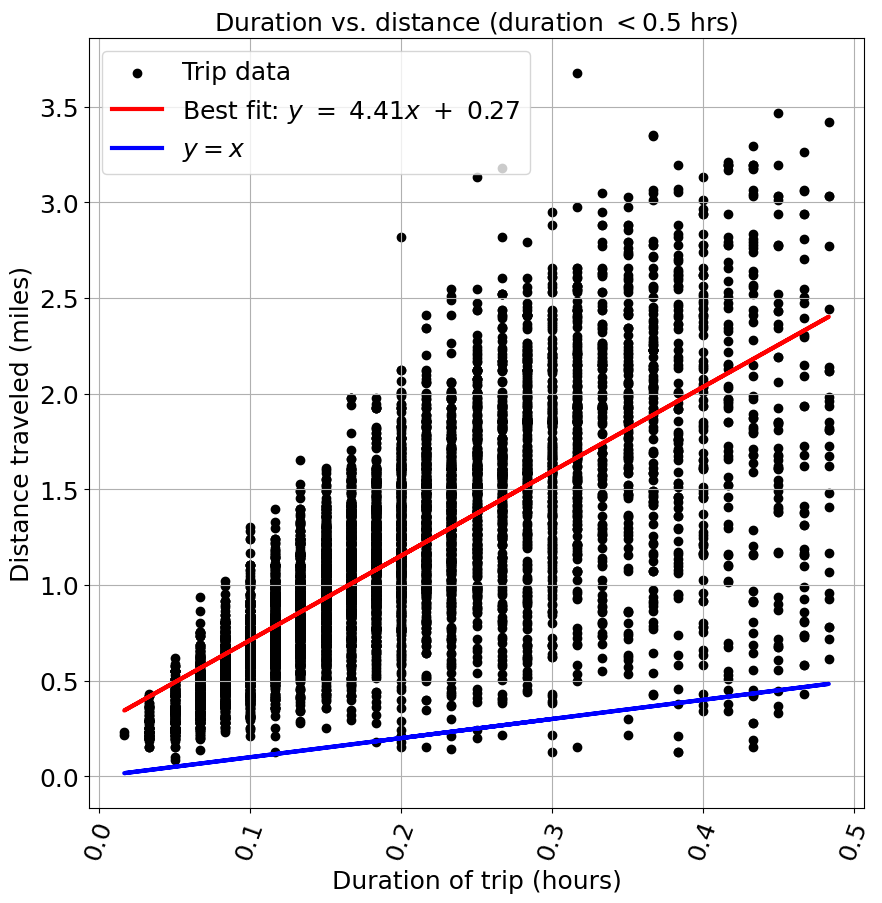

In [10]:
y = np.array([distances[i] for i in range(len(distances)) if hours[i] < 0.5])
x = np.array([hours[i] for i in range(len(hours)) if hours[i] < 0.5])

m, b, r, p, _ = stats.linregress(x,y)

RSQ = r**2

print("Our fit has a p-value of "+str(round(p, 2))+" and an R-squared of "+str(round(RSQ, 2))+".\nIt's a reasonable association, and we're pretty sure it's that strong.")

fig = plt.figure(figsize = (10,10))

plt.scatter(x, y,  color='black', label = "Trip data")
plt.plot(
    x, m*x + b, color='red',linewidth=3, 
    label = "Best fit: $y\ =\ $"+str(round(m,2))+"$x\ +\ $"+str(round(b, 2))
)
plt.plot(x, x, color='blue',linewidth=3, label = "$y = x$")

plt.xticks(rotation=70)

plt.xlabel('Duration of trip (hours)', fontsize = 18)
plt.ylabel('Distance traveled (miles)', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)

plt.title(r'Duration vs. distance (duration $ < 0.5$ hrs)', fontsize = 18)
plt.legend(fontsize = 18)

#### What do we see? Can we quantify the error?
Looking at our regression line (red), we can see that the best model predicts people will travel between stations roughly 4.5 miles apart for every hour they travel! Notice as well that there appears to be an upper limit of about one mile of distance for every hour of trip duration. To figure out how good of a predictor our best-line fit is, we can take the root mean squared error (RMSE) to estimate how far off (in miles) we'll usually be. Note that this should really be taken for the different durations, separately...

In [11]:
print("The overall RMSE is "+str(round(np.sqrt(np.mean((y - m*x + b)**2)), 5))+" miles!")

The overall RMSE is 0.65333 miles!


#### So what about the distributions?
Going back to the box plots, we might feel like we could say the distance data are non-normal, since there are so many upper outliers. Looking at a histogram, this looks like it may well be the case! Note: the red-dashed line is the normal distribution with the same mean and standard deviation&mdash;not a great match!

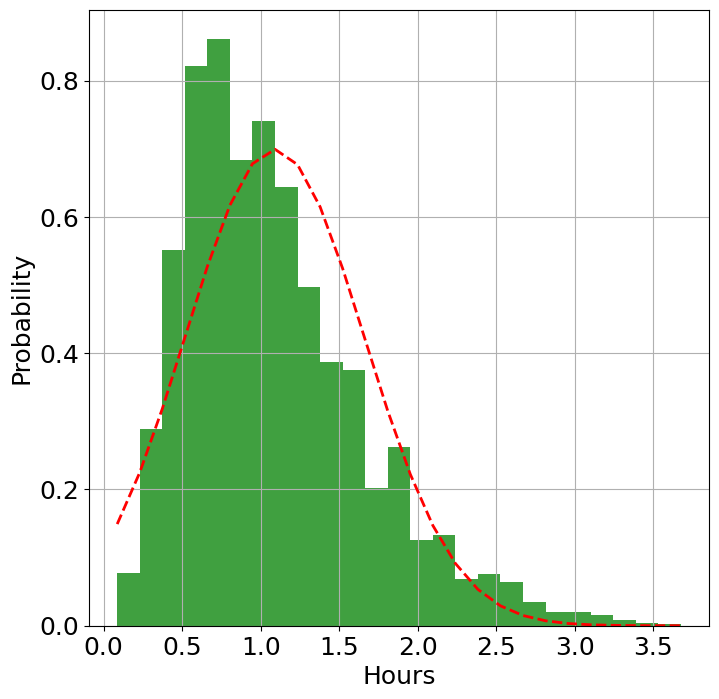

In [14]:
fig = plt.figure(figsize = (8,8))

mu, sigma = np.mean(distances), np.std(distances)


n, bins, patches = plt.hist(distances, 25, density=1, facecolor='green', alpha=0.75)

y = scipy.stats.norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth = 2, label = "A normal distribution")

plt.xlabel('Hours', fontsize = 18)
plt.ylabel('Probability', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)


#### But can we test our hypothesis?
Of course, there is a normal distribution test that comes with the scipy.stats module, which computs the $\chi^2$-statistic. Here, having a low p-value actually means we're confident the data are NOT derived from a normal distribution. Applying the test, it looks like they're not!

In [15]:
print(stats.mstats.normaltest(distances, axis=0))

NormaltestResult(statistic=1385.915048992785, pvalue=1.1281605729098452e-301)


### The MLB players' data
Let switch gears here now to a data set with a few more numeric features. Once again, inspect the data to se we we've got:

In [16]:
# Load the bike trips dataset
hw_data = pd.read_csv(filepath_or_buffer="baseball_heightweight.csv", sep=",", header=0)
print (hw_data[0:10])

              Name Team        Position  Height  Weight    Age
0    Adam_Donachie  BAL         Catcher      74   180.0  22.99
1        Paul_Bako  BAL         Catcher      74   215.0  34.69
2  Ramon_Hernandez  BAL         Catcher      72   210.0  30.78
3     Kevin_Millar  BAL   First_Baseman      72   210.0  35.43
4      Chris_Gomez  BAL   First_Baseman      73   188.0  35.71
5    Brian_Roberts  BAL  Second_Baseman      69   176.0  29.39
6    Miguel_Tejada  BAL       Shortstop      69   209.0  30.77
7      Melvin_Mora  BAL   Third_Baseman      71   200.0  35.07
8      Aubrey_Huff  BAL   Third_Baseman      76   231.0  30.19
9       Adam_Stern  BAL      Outfielder      71   180.0  27.05


#### Pre-processing, pre-processing, pre-processing
For convenience we're separating the columns, and as it turns out, there are some issues somewhere down in the data, so we've got to make sure that heights and weights are actually numbers before keeping them. We'll also keep the ages and positions, especially, as metadata.

In [17]:
heights = []
weights = []
ages = []
positions = []
for i in range(len(hw_data)):
    if not np.isnan(float(hw_data["Height"][i])) and not np.isnan(float(hw_data["Weight"][i])):
        heights.append(float(hw_data["Height"][i]))
        weights.append(float(hw_data["Weight"][i]))
        ages.append(float(hw_data["Age"][i]))
        positions.append(hw_data["Position"][i])
heights = np.array(heights)
weights = np.array(weights)
ages = np.array(ages)
positions = np.array(positions)

#### Are the heights and weights normal?
Looking at histogram, maybe. Remember, a drawback of histograms is that they are subject to binning. So even though I can bin them to resemble normal distributions, they may actually not have resulted from normality, despite the visual similarity. They definitely have a more-central tendency than the rideshare data. Note once again, that the dashed lines are the normal distributions having the same means/standard deviations.

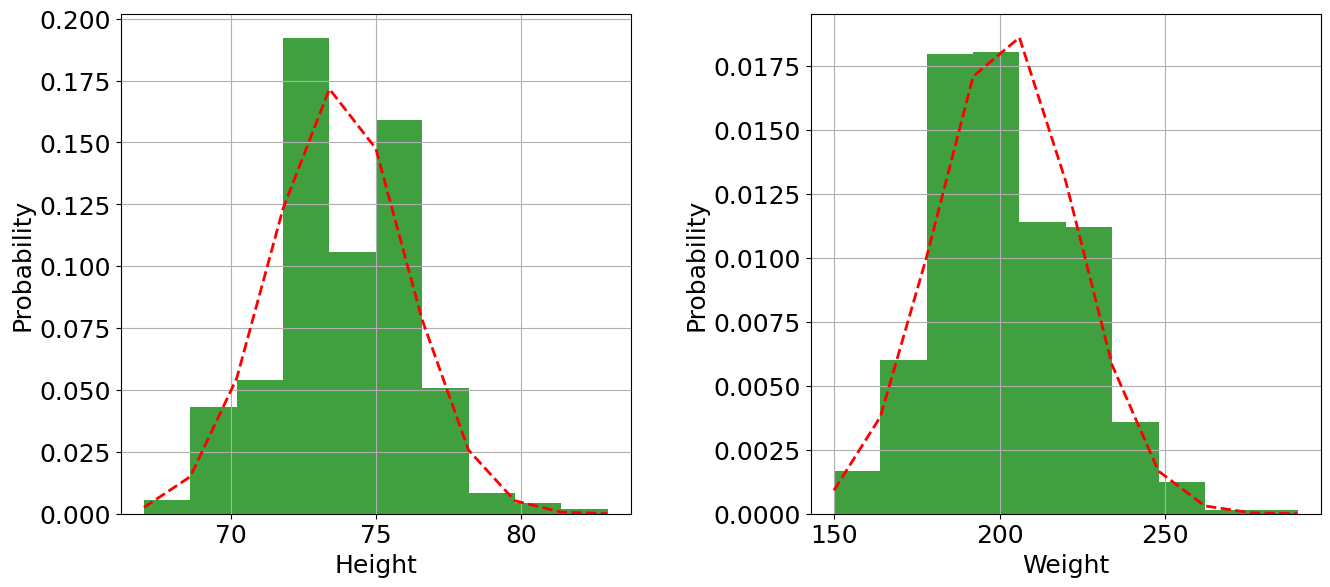

In [18]:
fig = plt.figure(figsize = (12,5))

first_ax = fig.add_axes([0, 0, 0.425, 1])

mu, sigma = np.mean(heights), np.std(heights)

n, bins, patches = plt.hist(heights, 10, density=1, facecolor='green', alpha=0.75)

y = scipy.stats.norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth = 2, label = "A normal distribution")

plt.xlabel('Height', fontsize = 18)
plt.ylabel('Probability', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)

second_ax = fig.add_axes([0.575, 0, 0.425, 1])

mu, sigma = np.mean(weights), np.std(weights)

n, bins, patches = plt.hist(weights, 10, density=1, facecolor='green', alpha=0.75)

y = scipy.stats.norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth = 2, label = "A normal distribution")

plt.xlabel('Weight', fontsize = 18)
plt.ylabel('Probability', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)

#### So, are they normal? I thought heights and weights were normal?
As it turns out, neither is likely the result of a normal distribution! The heights, however, are a bit closer, but ther weights are more-significantly off. So, why would heights and weights not be normal? Perhaps there is some bias going on with the types of figures being selected for baseball, and more specifically, the different playing positions of that game. Let's investigate.

In [19]:
print(stats.mstats.normaltest(heights, axis=0))
print(stats.mstats.normaltest(weights, axis=0))

NormaltestResult(statistic=12.68757548944434, pvalue=0.001757632150615037)
NormaltestResult(statistic=23.04027459691998, pvalue=9.928141093787018e-06)


#### First, let's compare heights vs. weights. Tall people weight more, right?
Yes, it's true that tall people do, on average, weight more, but notice that there is definitely some substantial noise around this signal, which according to our linear model, is likely linear.

Our fit has a p-value of 0.0 and an R-squared of 0.28.
It's not a terribly strong association, and we're pretty sure of that.


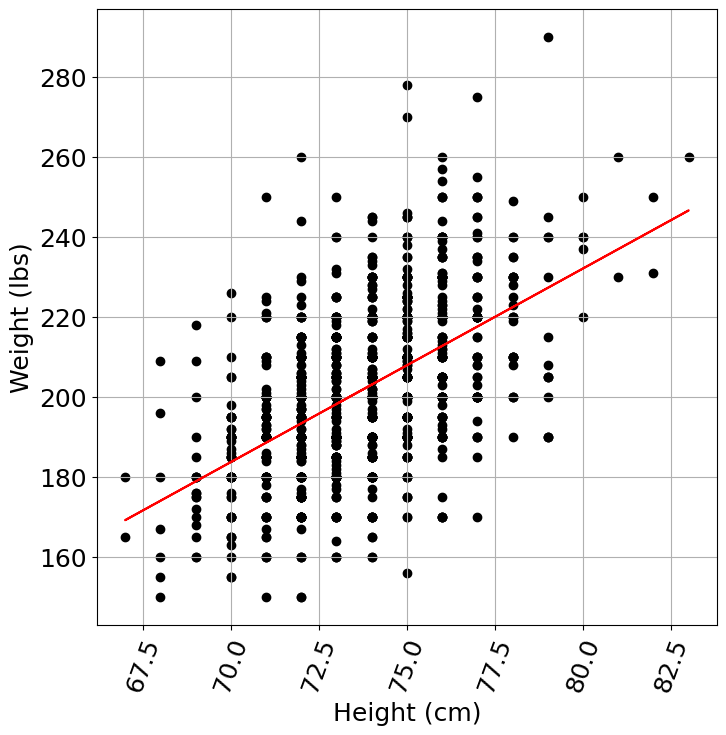

In [20]:
fig = plt.figure(figsize = (8,8))

m, b, r, p, _ = stats.linregress(heights,weights)

RSQ = r**2

print("Our fit has a p-value of "+str(round(p, 2))+" and an R-squared of "+str(round(RSQ, 2))+".\nIt's not a terribly strong association, and we're pretty sure of that.")

plt.scatter(heights, weights, color = 'black')
plt.plot(heights, heights*m + b, color = 'red')
plt.xticks(rotation=70)

plt.xlabel('Height (cm)', fontsize = 18)
plt.ylabel('Weight (lbs)', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)

#### So what's breaking down this realtionship? 
Well, it takes a special kind of person to play baseball, and it gets more specific with the different positions. Basebally is very specialized with its different activities. Let's look to see what the options for the positions are:

In [21]:
print(set(positions))

{'Third_Baseman', 'Relief_Pitcher', 'Catcher', 'Outfielder', 'Second_Baseman', 'Shortstop', 'Designated_Hitter', 'Starting_Pitcher', 'First_Baseman'}


#### If you know anything about baseball...
... you probably are aware that shortstops do some of the more cardiovascular work. Also, you're probably aware that the heavy hitters, especially the designated hitters, usually have a lot of bulk. Can we see this by plotting the two groups as different colors??

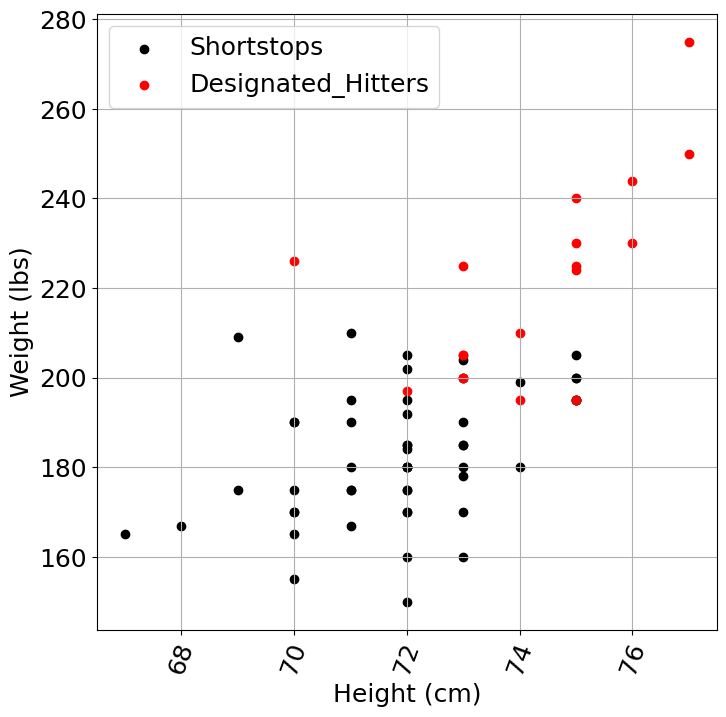

In [22]:
fig = plt.figure(figsize = (8,8))

# plt.scatter(heights[positions == "Catcher"], weights[positions == "Catcher"], color = 'black', label = "Catchers")
plt.scatter(heights[positions == "Shortstop"], weights[positions == "Shortstop"], color = 'black', label = "Shortstops")
plt.scatter(heights[positions == "Designated_Hitter"], weights[positions == "Designated_Hitter"], color = 'red', label = "Designated_Hitters")
plt.xticks(rotation=70)

plt.xlabel('Height (cm)', fontsize = 18)
plt.ylabel('Weight (lbs)', fontsize = 18)
plt.tick_params(labelsize=18)
plt.grid(True)
plt.legend(fontsize = 18)

#### Do you see the pattern?
It appears that there is a strong pattern, here, with shortstops being a little bit shorter, but significantly lighter. So, could we use these two attributes (height and weight) to tell the difference between shortstops and designated hitters? Yes, this is just a binary classification problem. Since they are the smaller class, let's call the designated hitters positives (1s) and the shortstops negatives (0s).

#### How will we classify them?
For simplicity, let's use a supervised machine learning method called a "support vecor machine":

* https://en.wikipedia.org/wiki/Support_vector_machine

specifically with a linear kernel. What this will do is determine the line that SEPARATES the two groups the best. To train our algorithm we have to do a bit more pre-processing to conform the `sklearn` modules input format, including coding the positions as 0s and 1s.

In [23]:
lsvm = svm.SVC(kernel='linear')

data = []
posits = []
for i, _ in enumerate(heights):
    if positions[i] == "Shortstop":
        posits.append(0)
        data.append([heights[i], weights[i]])
    elif positions[i] == "Designated_Hitter":
        posits.append(1)
        data.append([heights[i], weights[i]])
        
data = np.array(data)
posits = np.array(posits)
        
posits = np.array(posits)
lsvm.fit(data, posits)

SVC(kernel='linear')

#### Does it work? How do we apply the classifier?
We can see if the classifier works by putting in some made up heights and weights. Let's choose 72 cm/ 180 lbs for a shortstop and 76 cm/240 lbs for a designated hitter. It works!

In [24]:
print("Shortstop prediction: ", lsvm.predict([[72,180]]) )

print("Designated hitter prediction: ", lsvm.predict([[76,240]]))

Shortstop prediction:  [0]
Designated hitter prediction:  [1]


#### What does the classifier look like?
A linear SVM is just a line that cuts through the parameter space (here, height vs. weight). Let's take a look:

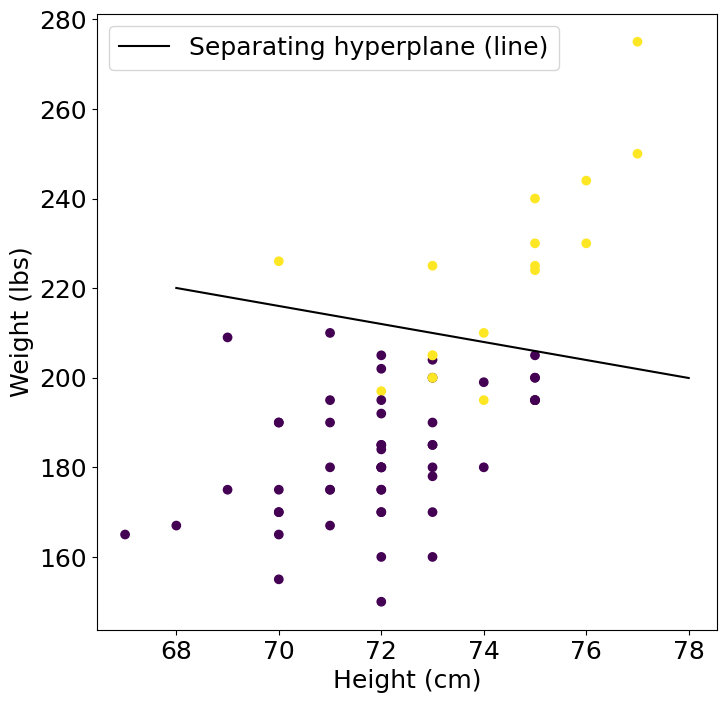

In [25]:
fig = plt.figure(figsize = (8,8))

w = lsvm.coef_[0]

m = -w[0] / w[1]

b = - lsvm.intercept_[0] / w[1]

xx = np.linspace(68,78)
yy = m * xx + b

h0 = plt.plot(xx, yy, 'k-', label="Separating hyperplane (line)")

plt.scatter(data[:, 0], data[:, 1], c = posits)
plt.xlabel('Height (cm)', fontsize = 18)
plt.ylabel('Weight (lbs)', fontsize = 18)
plt.tick_params(labelsize=18)
plt.legend(fontsize = 18)
plt.show()

#### So how well does our classifier separate data?
Since we have not broken our data down into training and testing sets, we'll just keep it simple and evaluate on our training data. Recall, a binary classifier is evaulated through confusion matrix metrics, like true positives and false positives, etc. To compute these, along with precision, recall, and $F_1$, we can loop through our training data apply the classifier, checking against the know predicted values.

In [26]:
confusion = {
    "TP": 0.,
    "FP": 0.,
    "TN": 0.,
    "FN": 0.
}
for i, (h, w) in enumerate(data):
    prediction = lsvm.predict([[h,w]])[0]
    truth = posits[i]
    if prediction and truth:
        confusion["TP"] += 1.
    elif prediction:
        confusion["FP"] += 1.
    elif truth:
        confusion["FN"] += 1.
    else:
        confusion["TN"] += 1.
confusion["P"] = confusion["TP"]/(confusion["TP"]+confusion["FP"])
confusion["R"] = confusion["TP"]/(confusion["TP"]+confusion["FN"])
confusion["F1"] = 2.*confusion["R"]*confusion["P"]/(confusion["R"] + confusion["P"])
for key in confusion:
    print(key+": "+str(confusion[key]))
 

TP: 11.0
FP: 0.0
TN: 52.0
FN: 7.0
P: 1.0
R: 0.6111111111111112
F1: 0.7586206896551725


# Questions

1. Calculate the accuracy for the above baseball model.
2. Observe that precision is 100% and recall is 61%. What does that mean?
3. Upload the notebook to your github and render it using https://nbviewer.org/ and share the kink in blackboard under Week 9 participation.

In [29]:
confusion["A"] = (confusion["TP"]+confusion["TN"])/(confusion["TP"]+confusion["FP"]+confusion["TN"]+confusion["FN"])
print("A"+": "+str(confusion["A"]))

A: 0.9


# Answer

1. The accuracy of the baseball model is 90%.
2. A precision of 100% means that 100% of all players we predict to be designated hitters are designated hitters. A 61% recall means that out of all designated hitters, we were able to classify 61% of them correctly. 